<a href="https://colab.research.google.com/github/RuslanFF1968/Pioneer/blob/main/NN_processing_of_sound_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

Achieve at least 79% accurate recognition of music genres consistently during the last epochs of learning.

Use a breakdown of 900 records for the training sample and 100 for the verification sample.


**Installing librosa**

In [ ]:
# Устанавливаем пакет librosa для работы с аудио
!pip install librosa==0.8.0
!pip install --upgrade librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 121.9 MB/s eta 0:00:00
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201361 sha256=45a30b884732aee55a4b7b54a203ee3a829021e93750d17dd2b6d454b268024b
  Stored in directory: /root/.cache/pip/wheels/22/43/85/87fcd952d6b6fd297bcfa375598bd027f484f799de151fa5c4
Successfully built librosa
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.0
    Uninstalling librosa-0.8.0:
      Successfully uninstalled librosa-0.8.0


**Importing the libraries**

In [ ]:
# Подключаем библиотеки
import sklearn
from IPython.display import Audio  # Воспроизведение аудиофайлов
import time                        # Для подсчёта времени
import zipfile                     # Для разорхивации базы
import pandas as pd                # Для работы с табличными данными
from tensorflow.keras import utils # Для to_categorical
from google.colab import files     # Загрузка файлов
import os                          # Работа с папками и файлами
import librosa                     # Параметризация аудио
import librosa.feature             # Инструменты для параметризации
import numpy as np                 # Numpy массивы
import matplotlib.pyplot as plt    # Отображение графиков

# Отрисовка графиков в ячейках collab
%matplotlib inline
from tensorflow.keras.optimizers import Adam, RMSprop # Оптимизатор для задания шага обучения
from keras.models import Sequential, Model # Два формата модели keras
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D, Reshape, Lambda # Базовые слови
from sklearn.model_selection import train_test_split    # Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler # Для нормировки данных
# from keras.layers.advanced_activations import LeakyReLU # Импортируем функцию активации отдельным слоем
from keras.layers import ELU, PReLU, LeakyReLU
from keras import backend as K                          # Устанавливаем переменную для окружения кераса

In [ ]:
# Подключаем Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Uploading the DB with songs**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile # Для разархивации базы

# Разорхивируем архив с базой
# z = zipfile.ZipFile('/content/drive/My Drive/Базы/genres.zip', 'r')
# z.extractall()

# Задаём названия жанров
# В архиве названия папок совпадают с названиями жанров
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

# Проверяем выгруженные папки
!ls drive/MyDrive/Базы/genres

# И одну из папок
!ls drive/MyDrive/Базы/genres/rock

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
rock.00000.au  rock.00020.au  rock.00040.au  rock.00060.au  rock.00080.au
rock.00001.au  rock.00021.au  rock.00041.au  rock.00061.au  rock.00081.au
rock.00002.au  rock.00022.au  rock.00042.au  rock.00062.au  rock.00082.au
rock.00003.au  rock.00023.au  rock.00043.au  rock.00063.au  rock.00083.au
rock.00004.au  rock.00024.au  rock.00044.au  rock.00064.au  rock.00084.au
rock.00005.au  rock.00025.au  rock.00045.au  rock.00065.au  rock.00085.au
rock.00006.au  rock.00026.au  rock.00046.au  rock.00066.au  rock.00086.au
rock.00007.au  rock.00027.au  rock.00047.au  rock.00067.au  rock.00087.au
rock.00008.au  rock.00028.au  rock.00048.au  rock.00068.au  rock.00088.au
rock.00009.au  rock.00029.au  rock.00049.au  rock.00069.au  rock.00089.au
rock.00010.au  rock.00030.au  rock.00050.au  rock.00070.au  rock.00090.au
rock.00011.au  rock.00031.au  rock.00051.au  rock.00071.au  rock.00091.au
rock.00012.au  rock.00032.au  rock.00052

**Audio parameterization function**

In [ ]:
# Функция параметризации аудио
def get_features_2d(y, sr):

  # Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)     # Частота цветности
  rmse = librosa.feature.rms(y=y)                          # Среднеквадратичная амплитуда
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) # Спектральный центроид
  mfcc = librosa.feature.mfcc(y=y, sr=sr)                   # Мел спектральные коэффициенты

  # Возвращаем получившийся список
  return mfcc, chroma_stft, rmse, spec_cent

**Creation of training sample**

In [ ]:
import time # Для подсчёта времени на обработку одного жанра

# Формируем обучающую выборку
# Создаём пустые листы
X_train_mfcc = []
X_train_chroma_stft = []
X_train_rmse = []
X_train_spec_cent = []
Y_train = []

# Запоминаем время старта формирования выборки
curr_time = time.time()

# Длина каждой записи первые 20 секунд
seconds = 20

# Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] # Берём текущий жанр

  # Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./drive/MyDrive/Базы/genres/{g}'):

    # Получаем имя песни
    songname = f'./drive/MyDrive/Базы/genres/{g}/{filename}'

    # Загружаем в y аудиосигнал
    # Используем первые %seconds% секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=seconds)

    # Превращаем сигнал в параметризованные данные
    for sec in range(seconds):
      mfcc, chroma_stft, rmse, spec_cent = get_features_2d(y[sec*sr:(sec+1)*sr], sr)
      X_train_mfcc.append(mfcc)
      X_train_chroma_stft.append(chroma_stft)
      X_train_rmse.append(rmse)
      X_train_spec_cent.append(spec_cent)
      Y_train.append(utils.to_categorical(i, len(genres)))

  # Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

# Превращаем обучающую выборку на numpy массивы
X_train_mfcc = np.array(X_train_mfcc)
X_train_chroma_stft = np.array(X_train_chroma_stft)
X_train_rmse = np.array(X_train_rmse)
X_train_spec_cent = np.array(X_train_spec_cent)
Y_train = np.array(Y_train)

Жанр blues готов -> 69c


/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Жанр classical готов -> 51c
Жанр country готов -> 44c
Жанр disco готов -> 47c
Жанр hiphop готов -> 62c
Жанр jazz готов -> 43c
Жанр metal готов -> 40c
Жанр pop готов -> 42c
Жанр reggae готов -> 41c
Жанр rock готов -> 42c


In [ ]:
# Решейпим данные для нейронки
X_train_mfcc = X_train_mfcc.reshape(X_train_mfcc.shape[0], X_train_mfcc.shape[1], X_train_mfcc.shape[2], 1)
X_train_chroma_stft = X_train_chroma_stft.reshape(X_train_chroma_stft.shape[0], X_train_chroma_stft.shape[1], X_train_chroma_stft.shape[2], 1)
X_train_rmse = X_train_rmse.reshape(X_train_rmse.shape[0], X_train_rmse.shape[2], X_train_rmse.shape[1])
X_train_spec_cent = X_train_spec_cent.reshape(X_train_spec_cent.shape[0], X_train_spec_cent.shape[2], X_train_spec_cent.shape[1])

In [ ]:
print(X_train_mfcc.shape)
print(X_train_chroma_stft.shape)
print(X_train_rmse.shape)
print(X_train_spec_cent.shape)

(20000, 20, 44, 1)
(20000, 12, 44, 1)
(20000, 44, 1)
(20000, 44, 1)


In [ ]:
# Создаем маску для обучающей и проверочной выборки
val_mask = np.random.sample(20000)
train_mask = val_mask < 0.9
val_mask = val_mask >= 0.9

In [ ]:
# Функция нормализации
def scale(X):
  min_X = X.min()
  max_X = X.max()
  X = (X - min_X) / (max_X - min_X)
  return X

In [ ]:
# Нормализация
X_train_mfcc_scaled = scale(X_train_mfcc)
X_train_chroma_stft_scaled = scale(X_train_chroma_stft)
X_train_rmse_scaled = scale(X_train_rmse)
X_train_spec_cent_scaled = scale(X_train_spec_cent)

##NN creation

In [ ]:
input_mfcc = Input((20, 44, 1))        # Входной слой для mfcc
input_chroma_stft = Input((12, 44, 1)) # Входной слой для chroma_stft
input_rmse = Input((44, 1))            # Входной слой для rmse
input_spec_cent = Input((44, 1))       # Входной слой для spec_cent

# Блок mfcc
x1 = BatchNormalization()(input_mfcc)
x1 = Conv2D(256, (3,3), padding="same", activation="elu")(x1)
x1 = Conv2D(256, (3,3), padding="same", activation="elu")(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Conv2D(128, (3,3), padding="same", activation="elu")(x1)
x1 = Conv2D(128, (3,3), padding="same", activation="elu")(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Conv2D(64, (3,3), padding="same", activation="elu")(x1)
x1 = Conv2D(64, (3,3), padding="same", activation="elu")(x1)
x1 = Flatten()(x1)

# Блок chroma_stft
x2 = BatchNormalization()(input_chroma_stft)
x2 = Conv2D(256, (3,3), padding="same", activation="elu")(x2)
x2 = Conv2D(256, (3,3), padding="same", activation="elu")(x2)
x2_gmp_1 = GlobalMaxPooling2D()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(128, (3,3), padding="same", activation="elu")(x2)
x2 = Conv2D(128, (3,3), padding="same", activation="elu")(x2)
x2_gmp_2 = GlobalMaxPooling2D()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(64, (3,3), padding="same", activation="elu")(x2)
x2 = Conv2D(64, (3,3), padding="same", activation="elu")(x2)
x2_gmp_3 = GlobalMaxPooling2D()(x2)
x2 = Flatten()(x2)

# Блок rmse
x3 = BatchNormalization()(input_rmse)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Flatten()(x3)

# Блок spec_cent
x4 = BatchNormalization()(input_spec_cent)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Flatten()(x4)

# Объедияем все блоки
x = concatenate([x1, x2, x3, x4, x2_gmp_1, x2_gmp_2, x2_gmp_3])

# Полносвязные слои на выходе
x = Dense(128, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model([input_mfcc, input_chroma_stft, input_rmse, input_spec_cent], x)

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 75s 309ms/step - accuracy: 0.4028 - loss: 1.7668 - val_accuracy: 0.0974 - val_loss: 6.1098 - learning_rate: 0.0010
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.6633 - loss: 0.9546 - val_accuracy: 0.2597 - val_loss: 5.1924 - learning_rate: 0.0010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.7537 - loss: 0.7119 - val_accuracy: 0.5667 - val_loss: 1.3002 - learning_rate: 0.0010
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.7989 - loss: 0.5739 - val_accuracy: 0.6719 - val_loss: 0.9544 - learning_rate: 0.0010
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - accuracy: 0.8257 - loss: 0.4999 - val_accuracy: 0.7649 - val_loss: 0.8283 - learning_rate: 0.0010
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.8676 - loss: 0.3844 - val_accuracy: 0.7831 - val_loss: 0.7510 - learning_rate: 0.0010
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.9

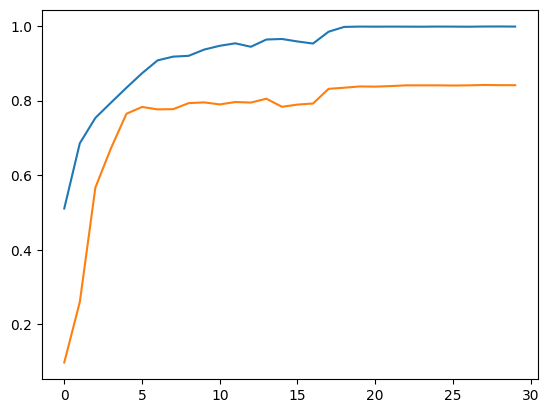

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Добавляем колбэк ReduceLROnPlateau для уменьшения шага обучения
reduce_ = ReduceLROnPlateau(monitor='val_loss')

# Обучаем модель
history = model.fit([X_train_mfcc_scaled[train_mask], X_train_chroma_stft_scaled[train_mask], X_train_rmse_scaled[train_mask], X_train_spec_cent_scaled[train_mask]],
                    Y_train[train_mask],
                    epochs=30,
                    batch_size=128,
                    validation_data=([X_train_mfcc_scaled[val_mask], X_train_chroma_stft_scaled[val_mask], X_train_rmse_scaled[val_mask], X_train_spec_cent_scaled[val_mask]],
                    Y_train[val_mask]),
                    callbacks=[reduce_])

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()